In [2]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

data_clean_1089 = np.load('/kaggle/input/wasser/1512_2_compressed.npz')['arr_0'] #zu faul gewesen den Namen des arrays der Größe anzupassen
data_clean_1089 = data_clean_1089.astype(np.float16)

corrected_base_data2 = np.load('/kaggle/input/wasser/data_clean_2_compressed.npz')['arr_0']
data_clean_1089 = data_clean_1089[:,:1212]
print(corrected_base_data2.shape)


input_dim = 852 
output_dim = 360

y_train = data_clean_1089[:int(data_clean_1089.shape[0]*0.9) , input_dim:] 
X_train = data_clean_1089[:int(data_clean_1089.shape[0]*0.9) , :input_dim] 
X_test = data_clean_1089[int(data_clean_1089.shape[0]*0.9): , :input_dim] 
y_test = data_clean_1089[int(data_clean_1089.shape[0]*0.9): , input_dim:]

X_train, X_val, y_train, y_val = train_test_split(X_train[::5], y_train[::5], test_size=0.15, shuffle=True) 
X_test_plot = X_test 

temp = int((data_clean_1089.shape[0] - 0) * 0.9)  #nur zum plotten

(2938653, 13)


In [4]:
from sklearn.metrics import mean_absolute_error
feature_cutoff = 12
def plot(real_data, prediction, autoreg_steps, start_point, input_dim, output_dim):
    test_input = real_data[start_point : input_dim+start_point] * 1000
    test_output_real = real_data[input_dim+start_point : input_dim+start_point+output_dim*autoreg_steps] * 1000

    zeitachse_blau = np.arange(input_dim)
    zeitachse_gruen = np.arange(input_dim, output_dim*autoreg_steps + input_dim)

    # Plot der ersten 360 Messungen in blau
    plt.plot(zeitachse_blau, test_input, color='blue')
    ######
    plt.plot(zeitachse_gruen, test_output_real, color='green')

    plt.plot(zeitachse_gruen, prediction , color='red')
    # Plot anzeigen
    #plt.show()
    mae = mean_absolute_error(test_output_real, prediction)
    abs_error = np.max(np.abs(test_output_real-prediction))
    #print(mae)
    #print(abs_error)
    return mae, abs_error
    

def prediction_maker2(input, model, autoreg_steps, input_dim, output_dim, additional_input_data):
    #input = input 
    input = input.reshape(1,input_dim,1)
    prediction_array = []
    
    for i in range(autoreg_steps):

        next_prediction = model.predict(input, verbose=0) 
        prediction_array = np.append(prediction_array, next_prediction )

        next_prediction = next_prediction.reshape(1, output_dim, 1)
       

        temp1, input = np.split(input, [feature_cutoff], axis=1)
        input = np.append(input, next_prediction, axis=1)
        input = np.roll(input, shift=-output_dim, axis=1)
        input = input[:, :-output_dim, :]
        
        
        temp1 = additional_input_data[(i+1) * output_dim, :feature_cutoff] 
        temp1 = temp1.reshape(1,temp1.shape[0],1)
        input = np.concatenate((temp1,input), axis = 1)
        

  
    
    return prediction_array * 1000


def multiple_plots2(input_data, input_dim, output_dim, autoreg_steps, X_test):
    
    plot_cutoff = input_dim+ output_dim*autoreg_steps #man nimmt nicht die gesamte breite von X_test, sondern lässt am ende noch etwas platz
    
    mae = []
    max_abs_error = []
    
    for i in np.random.randint(plot_cutoff, size=200):   
        arr2 = prediction_maker2(X_test[i], model, autoreg_steps, input_dim, output_dim, input_data[i  : i  + input_dim + autoreg_steps * output_dim, :])       
        arr2 = arr2.reshape(len(arr2))
        temp1, temp2 = plot(input_data[:,-1], arr2, autoreg_steps, i , input_dim, output_dim)
        mae.append(temp1)
        max_abs_error.append(temp2)

    
    print('________________________________')
    print('average mae: ', np.average(mae))
    #print('average max_abs_error: ', np.average(max_abs_error))
    return np.average(mae)
    

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization # mit zyjklischen zeitangaben embeddings eher schlecht, sollte ich vll lassen
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LayerNormalization
# Batch-Größe

#  Sichere Generator-Funktion mit `yield`
def data_generator(X, y, batch_size):
    num_samples = X.shape[0]
    indices = np.arange(num_samples)

    while True:  # Endloser Generator für `from_generator()`
        np.random.shuffle(indices)
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_idx = indices[start:end]

            X_batch = X[batch_idx].astype(np.float16)  
            y_batch = y[batch_idx].astype(np.float16)

            yield X_batch, y_batch  #  Generator gibt Batch zurück

# `tf.data.Dataset` richtig erstellen
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_train, y_train, batch_size),  
    output_signature=(
        tf.TensorSpec(shape=(None, input_dim), dtype=tf.float16),
        tf.TensorSpec(shape=(None, output_dim), dtype=tf.float16)
    )
).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_val, y_val, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, input_dim), dtype=tf.float16),
        tf.TensorSpec(shape=(None, output_dim), dtype=tf.float16)
    )
).prefetch(tf.data.AUTOTUNE)

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Überwacht die Fehler auf den Validierungsdaten
    #patience=10,          # Stoppt nach 5 Epochen ohne Verbesserung
    restore_best_weights=True
)

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# Step 1: Save the best model as `.keras` (since Keras requires it)
#checkpoint_callback = ModelCheckpoint(
#    "best_model1.keras",  # Use .keras as required
#    monitor="val_loss",  
#    save_best_only=True,  
#    mode="min",  
#    verbose=1  
#)

Training with 1 layers, 250 neurons, lr=0.001, opt=Adam, batch_size=350, epochs=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.00089, saving model to best_temp_model.keras

Epoch 2: val_loss improved from 0.00089 to 0.00068, saving model to best_temp_model.keras

Epoch 3: val_loss improved from 0.00068 to 0.00066, saving model to best_temp_model.keras
________________________________
average mae:  23.549086775423753
New best MAE: 23.549086775423753, saving model...
Training with 1 layers, 250 neurons, lr=0.001, opt=Adam, batch_size=350, epochs=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.00077, saving model to best_temp_model.keras

Epoch 2: val_loss improved from 0.00077 to 0.00065, saving model to best_temp_model.keras
________________________________
average mae:  22.38545754862328
New best MAE: 22.38545754862328, saving model...
Training with 1 layers, 250 neurons, lr=0.001, opt=Adam, batch_size=350, epochs=4


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.00099, saving model to best_temp_model.keras

Epoch 2: val_loss improved from 0.00099 to 0.00084, saving model to best_temp_model.keras

Epoch 3: val_loss improved from 0.00084 to 0.00063, saving model to best_temp_model.keras

Epoch 4: val_loss did not improve from 0.00063
________________________________
average mae:  18.468830480550725
New best MAE: 18.468830480550725, saving model...
Training with 1 layers, 250 neurons, lr=0.005, opt=Adam, batch_size=350, epochs=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.00089, saving model to best_temp_model.keras

Epoch 2: val_loss improved from 0.00089 to 0.00078, saving model to best_temp_model.keras

Epoch 3: val_loss improved from 0.00078 to 0.00064, saving model to best_temp_model.keras
________________________________
average mae:  23.405033678437277
Training with 1 layers, 250 neurons, lr=0.005, opt=Adam, batch_size=350, epochs=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.00101, saving model to best_temp_model.keras

Epoch 2: val_loss improved from 0.00101 to 0.00077, saving model to best_temp_model.keras
________________________________
average mae:  30.744222731846904
Training with 1 layers, 250 neurons, lr=0.005, opt=Adam, batch_size=350, epochs=4


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.00089, saving model to best_temp_model.keras

Epoch 2: val_loss did not improve from 0.00089

Epoch 3: val_loss improved from 0.00089 to 0.00087, saving model to best_temp_model.keras

Epoch 4: val_loss improved from 0.00087 to 0.00065, saving model to best_temp_model.keras
________________________________
average mae:  27.91979958986242
Training with 1 layers, 350 neurons, lr=0.001, opt=Adam, batch_size=350, epochs=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.00073, saving model to best_temp_model.keras

Epoch 2: val_loss improved from 0.00073 to 0.00069, saving model to best_temp_model.keras

Epoch 3: val_loss improved from 0.00069 to 0.00056, saving model to best_temp_model.keras
________________________________
average mae:  26.26428304860989
Training with 1 layers, 350 neurons, lr=0.001, opt=Adam, batch_size=350, epochs=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.00098, saving model to best_temp_model.keras

Epoch 2: val_loss improved from 0.00098 to 0.00066, saving model to best_temp_model.keras
________________________________
average mae:  22.333963529310296
Training with 1 layers, 350 neurons, lr=0.001, opt=Adam, batch_size=350, epochs=4


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.00084, saving model to best_temp_model.keras

Epoch 2: val_loss improved from 0.00084 to 0.00071, saving model to best_temp_model.keras

Epoch 3: val_loss did not improve from 0.00071

Epoch 4: val_loss improved from 0.00071 to 0.00061, saving model to best_temp_model.keras
________________________________
average mae:  19.89286463583509
Training with 1 layers, 350 neurons, lr=0.005, opt=Adam, batch_size=350, epochs=3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.00082, saving model to best_temp_model.keras

Epoch 2: val_loss did not improve from 0.00082

Epoch 3: val_loss improved from 0.00082 to 0.00078, saving model to best_temp_model.keras
________________________________
average mae:  36.378986318285264
Training with 1 layers, 350 neurons, lr=0.005, opt=Adam, batch_size=350, epochs=2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.00092, saving model to best_temp_model.keras

Epoch 2: val_loss did not improve from 0.00092
________________________________
average mae:  17.809662549446028
New best MAE: 17.809662549446028, saving model...
Training with 1 layers, 350 neurons, lr=0.005, opt=Adam, batch_size=350, epochs=4


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.00098, saving model to best_temp_model.keras

Epoch 2: val_loss did not improve from 0.00098

Epoch 3: val_loss improved from 0.00098 to 0.00075, saving model to best_temp_model.keras

Epoch 4: val_loss improved from 0.00075 to 0.00075, saving model to best_temp_model.keras
________________________________
average mae:  25.530344346124267
Hyperparameter-Tuning abgeschlossen. Beste MAE: 17.809662549446028


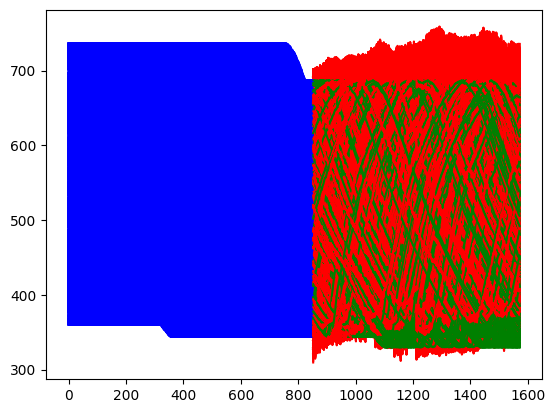

In [12]:
import itertools
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint


# Mögliche Hyperparameter
neurons = [ 250,350]
layers = [1]
learning_rates = [0.001, 0.005]
optimizers = [Adam]
batch_sizes = [350]
epochs_list = [ 3,2,4 ]

best_mae = float('inf')  # Initial sehr hoch

# Alle Kombinationen durchgehen
for neuron_count, layer_count, lr, opt, batch_size, epochs in itertools.product(
    neurons, layers, learning_rates, optimizers, batch_sizes, epochs_list):
    
    print(f"Training with {layer_count} layers, {neuron_count} neurons, lr={lr}, opt={opt.__name__}, batch_size={batch_size}, epochs={epochs}")

    checkpoint_callback = ModelCheckpoint("best_temp_model.keras", monitor="val_loss", save_best_only=True, mode="min", verbose=1)
    
    # Modell erstellen
    model = Sequential([Flatten(input_shape=(input_dim,))])
    for _ in range(layer_count):
        model.add(Dense(neuron_count, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(output_dim, activation='linear'))
    
    # Optimizer mit passender Lernrate
    optimizer = opt(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    # Training
    model.fit(
        train_dataset,
        epochs=epochs,
        steps_per_epoch=len(X_train) // batch_size,
        validation_data=test_dataset,
        validation_steps=len(X_val) // batch_size,
        verbose=0,  # Weniger Output
        callbacks=[checkpoint_callback]
    )
    #model = load_model("best_temp_model.keras")
    
    # MAE berechnen
    mae = multiple_plots2(corrected_base_data2[temp:, :], input_dim, output_dim, 2, X_test_plot)
    
    # Bestes Modell speichern
    if mae < best_mae:
        best_mae = mae
        print(f"New best MAE: {mae}, saving model...")
        model.save("best_model.keras")
        model.save("best_model.h5")

print(f"Hyperparameter-Tuning abgeschlossen. Beste MAE: {best_mae}")


________________________________
average mae:  18.148595174981487


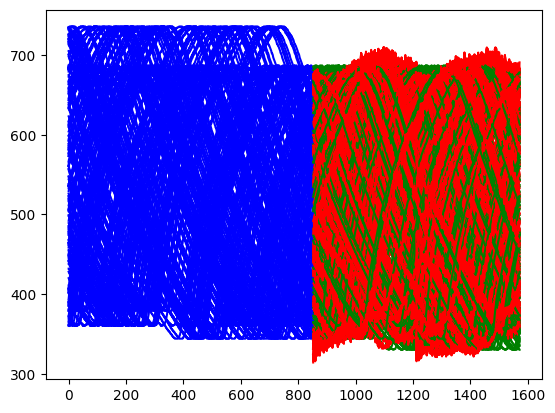

In [15]:
from keras.losses import MeanSquaredError

model = load_model("best_model.h5", custom_objects={"mse": MeanSquaredError()})
mae = multiple_plots2(corrected_base_data2[temp:, :], input_dim, output_dim, 2, X_test_plot)

In [5]:
model.save("fnn_852_2.h5")